# Run Correlation-Based Analyses

### Authors: Calvin Howard.

#### Last updated: July 6, 2023

Use this to assess if a correlation between a dependent variable and an independent variable is statistically significant using permutation analysis. 

Further, follow this up with a contrast analysis which sees which categorical variables have significantly different correlations from each other. 

Notes:
- To best use this notebook, you should be familar with mixed effects models

# 00 - Import CSV with All Data
**The CSV is expected to be in this format**
- ID and absolute paths to niftis are critical
```
+-----+----------------------------+--------------+--------------+--------------+
| ID  | Nifti_File_Path            | Covariate_1  | Covariate_2  | Covariate_3  |
+-----+----------------------------+--------------+--------------+--------------+
| 1   | /path/to/file1.nii.gz      | 0.5          | 1.2          | 3.4          |
| 2   | /path/to/file2.nii.gz      | 0.7          | 1.4          | 3.1          |
| 3   | /path/to/file3.nii.gz      | 0.6          | 1.5          | 3.5          |
| 4   | /path/to/file4.nii.gz      | 0.9          | 1.1          | 3.2          |
| ... | ...                        | ...          | ...          | ...          |
+-----+----------------------------+--------------+--------------+--------------+
```

In [ ]:
# Specify the path to your CSV file containing NIFTI paths
input_csv_path = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/cognition_2023/metadata/demographics.csv'
sheet = None #'master_list_proper_subjects' 

In [ ]:
# Specify where you want to save your results to
out_dir = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/cognition_2023/revisions/baselien_cognition'

In [ ]:
from calvin_utils.permutation_analysis_utils.statsmodels_palm import CalvinStatsmodelsPalm
# Instantiate the PalmPrepararation class
cal_palm = CalvinStatsmodelsPalm(input_csv_path=input_csv_path, output_dir=out_dir, sheet=sheet)
# Call the process_nifti_paths method
data_df = cal_palm.read_and_display_data()


# 01 - Preprocess Your Data

**Handle NANs**
- Set drop_nans=True is you would like to remove NaNs from data
- Provide a column name or a list of column names to remove NaNs from

In [ ]:
data_df.columns

In [ ]:
drop_list = ['Z_Scored_Percent_Cognitive_Improvement', 'Standardized_Cognitive_Baseline']

In [ ]:
data_df = cal_palm.drop_nans_from_columns(columns_to_drop_from=drop_list)
display(data_df)

**Drop Row Based on Value of Column**

Define the column, condition, and value for dropping rows
- column = 'your_column_name'
- condition = 'above'  # Options: 'equal', 'above', 'below'

Set the parameters for dropping rows

In [ ]:
data_df.columns
# data_df.City.unique()

In [ ]:
column = 'Cognitive_Test'  # The column you'd like to evaluate
condition = 'equal'  # Thecondition to check ('equal', 'above', 'below', 'not')
value = 'UPDRS-1' # The value to compare against

In [ ]:
data_df, other_df = cal_palm.drop_rows_based_on_value(column, condition, value)
data_df

Regress out a Covariate

In [ ]:
lis = []
for col in data_df.columns:
    if 'surface' in col.lower():
        lis.append(col)
print(lis)

In [ ]:
from calvin_utils.statistical_utils.regression_utils import RegressOutCovariates
# use this code block to regress out covariates. Generally better to just include as covariates in a model..
dependent_variable_list = lis
regressors = ['Age', 'Sex']

data_df, adjusted_dep_vars_list = RegressOutCovariates.run(df=data_df, dependent_variable_list=dependent_variable_list, covariates_list=regressors)
print(adjusted_dep_vars_list)

**Standardize Data**
- Enter Columns you Don't want to standardize into a list

In [ ]:
data_df.columns

In [ ]:
# Remove anything you don't want to standardize
cols_not_to_standardize = ['TOTAL11']

In [ ]:
data_df = cal_palm.standardize_columns(cols_not_to_standardize)
data_df

In [ ]:
data_df.describe()

Standardize Columns by Specific Category Groups

In [ ]:
# Assuming your DataFrame is named data_df and you want to standardize 'Measurement' within each 'Tissue' group

# Standardize 'Measurement' within each 'Tissue' group
data_df['Measurement'] = data_df.groupby('Tissue')['Measurement'].transform(lambda x: (x - x.mean()) / x.std())

# Print or inspect the resulting DataFrame
data_df


# 02 - Perform Basic Correlation

Variables to Correlate
- dependent_variable = 'Z_Scored_Percent_Cognitive_Improvement'
- independent_variable_list = ['Z_Scored_Cognitive_Baseline']


In [ ]:
data_df.columns

In [ ]:
y_variables_list = ['Z_Scored_Percent_Cognitive_Improvement']
x_variable_list = [ 'Standardized_Cognitive_Baseline']

Enter a column for categories (optional)

In [ ]:
cat_col = 'Cognitive_Test' #'City'

Choose Correlation Method
- Options: 'spearman', 'pearson', 'kendall'

In [ ]:
correlation = 'spearman'

Define plot Labels
- These are the axes

In [ ]:
# Axis Labels
x_label = 'Standardized Cognitive Baseline'
y_label = 'Standardized Cognitive Outcome'

Run the Correlation

In [ ]:
from calvin_utils.statistical_utils.scatterplot import ScatterplotGenerator 
for y_var in y_variables_list:
    generator = ScatterplotGenerator(dataframe=data_df, data_dict={y_var: x_variable_list}, 
                                    x_label=x_label, y_label=y_label, correlation=correlation, 
                                    palette='tab10',
                                    rows_per_fig=1, cols_per_fig=2,
                                    ylim=None,
                                    out_dir=out_dir,
                                    category_col=cat_col)
    generator.run()

Bootstrap it
- Accepts only 1 x and 1 y var from the above lists. 

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr

def bootstrap_correlation(data_df, x_var, y_var, n_bootstraps=1000):
    correlations = []
    
    for i in range(n_bootstraps):
        # Bootstrap sampling with replacement
        bootstrap_sample = data_df.sample(n=len(data_df), replace=True, random_state=i)
        
        # Calculate correlation
        corr, _ = spearmanr(bootstrap_sample[x_var], bootstrap_sample[y_var])
        
        if corr is not np.nan: correlations.append(corr)
    
    # Convert to numpy array for easier manipulation
    correlations = np.array(correlations)
    
    # Calculate the required statistics
    lower_extreme = np.min(correlations)
    lower_quartile = np.percentile(correlations, 25)
    median_corr = np.median(correlations)
    upper_quartile = np.percentile(correlations, 75)
    upper_extreme = np.max(correlations)
    
    return {
        'lower_extreme': lower_extreme,
        'lower_quartile': lower_quartile,
        'median': median_corr,
        'upper_quartile': upper_quartile,
        'upper_extreme': upper_extreme
    }


In [ ]:

result = bootstrap_correlation(data_df, x_variable_list[0], y_variables_list[0], n_bootstraps=1000)


Plot Based on the Bootstap

In [ ]:
data_df.columns

In [ ]:
x_variable_list = [ 'frontal_eh', 'parietal_eh','occipital_eh',  'temporal_eh', 'mesial_temporal_eh', 'cerebellum_eh', 'ventricle_eh']

In [ ]:
out_dir = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/atrophy_seeds_2023/Figures/association_to_baseline/lineplot'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

def bootstrap_correlation(data_df, x_var_list, y_var, n_bootstraps=1000):
    x_var_dict = {}
    for x_var in x_var_list:
        correlations = []
        
        while len(correlations) < n_bootstraps:
            # Bootstrap sampling with replacement
            bootstrap_sample = data_df.sample(n=len(data_df), replace=True)
            # Calculate correlation
            try:
                corr, _ = spearmanr(bootstrap_sample[x_var], bootstrap_sample[y_var])
            except:
                continue
            if corr is not np.nan: correlations.append(corr)
        # Convert to numpy array for easier manipulation
        correlations = np.array(correlations)
        x_var_dict[x_var] = correlations
        
    return x_var_dict

def plot_horizontal_lineplot(x_var_dict, out_dir, stdev=True):
    
    plt.figure(figsize=(len(x_var_dict) * 2, 6))  # Adjust width based on the number of x_vars

    x_vars = list(x_var_dict.keys())
    means = []
    lows = []
    highs = []

    # Calculate statistics for each x_var
    for x_var, correlations in x_var_dict.items():
        mean_corr = np.mean(correlations)
        means.append(mean_corr)
        
        if stdev:
            low = mean_corr - np.std(correlations)
            high = mean_corr + np.std(correlations)
        else:
            low = np.percentile(correlations, 2.5)
            high = np.percentile(correlations, 97.5)
        
        lows.append(low)
        highs.append(high)
    
    # Plot the confidence interval as a filled area, connecting each point
    plt.fill_between(x_vars, lows, highs, color='lightblue', alpha=0.5)
    
    # Plot the mean correlation as a line
    plt.plot(x_vars, means, 'o-', color='blue')
    
    plt.xlabel('X Variables')
    plt.ylabel('Correlation')
    plt.title('Line Plot of Mean and 95% CI for Each X Variable')
    plt.ylim((-.2, 0.75))
    plt.savefig(os.path.join(out_dir, 'nrad_lineplot.svg'))
    plt.show()

plot_horizontal_lineplot(bootstrap_correlation(data_df, x_var_list=x_variable_list, y_var=y_variables_list[0]), out_dir)


Overlay Correlations for Visualization

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def overlay_lmplots_with_correlation(data_df, ivs, dv, colors=None,labels=['GM', 'WM', 'CT', 'Radiologist', 'CSF']):
    """
    Generate and overlay lmplot graphs for each IV against the DV, with the legend showing the correlation value.

    Parameters:
    data_df (pd.DataFrame): The dataframe containing the data.
    ivs (list of str): List of independent variables (column names) in the dataframe.
    dv (str): Dependent variable (column name) in the dataframe.
    colors (list of str, optional): List of color hex codes. If None, defaults to 'tab10' palette.

    Returns:
    None: Displays the plot.
    """
    if colors is None:
        colors = sns.color_palette("tab10", len(ivs))
    
    plt.figure(figsize=(3, 3))
    
    if labels is None:
        labels = ivs
    
    jitter = 0.08
    for i, iv in enumerate(ivs):
        jittered_df = data_df.copy()
        jittered_df[dv] = jittered_df[dv] + jitter*i
        correlation = data_df[iv].corr(data_df[dv], method='spearman')
        sns.regplot(
            truncate=False,
            x=iv, 
            y=dv, 
            data=jittered_df, 
            scatter_kws={"s": 20, "color": colors[i]},  # Customize scatter plot size and color
            line_kws={"color": colors[i]}, 
            ci=None,
            label=f'{labels[i]} (r={correlation:.2f})'  # Adding correlation to legend
        )
        

    plt.legend(title="Methods", frameon=False, loc='best')
    # plt.ylim(-0.1,3.25)
    plt.xlabel("Atrophy (Z-score)")
    plt.ylabel('ADAS-Cog 13')
    plt.title('Ventricle')
    sns.despine()
    plt.savefig('/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/atrophy_seeds_2023/Figures/correlation_to_radiologist/radiologist/z_score_correlations/figures_of_each_lobe/Ventricle.svg')
    plt.show()

# Example usage:
# overlay_lmplots_with_correlation(data_df, ['IV1', 'IV2', 'IV3'], 'DV', ['#1f77b4', '#ff7f0e', '#2ca02c'])


In [ ]:
data_df.columns

In [ ]:
dv = 'Z_Scored_Percent_Cognitive_Improvement'
iv_list = [ 'Standardized_Cognitive_Baseline']
colour_list = ['#3A923A', '#C03D3E', '#E1812C', '#9372B2', '#3274A1']

In [ ]:
overlay_lmplots_with_correlation(data_df, iv_list, dv, colour_list)

# Visualize Correlational ANCOVA
- Accepts up to 2 categorical variables, allowing comparison of correlations across and within categories.
- Categorical variable - this will group correlations into a single subplot
- Cohort variable - this is a second variable, not visualized, which is used for statistical comparisons

Enter these values

In [ ]:
for col in data_df.columns:
    print(col)

In [ ]:
# Assuming data_prep and category_dataframes are already defined
dependent_variable = 'Q14'
independent_variable = 'Measurement'
categorical_variable = 'Tissue'
cohort_variable = 'Region'
correlation_method = 'spearman'

Visualize

In [ ]:
from calvin_utils.statistical_utils.delta_r import CombinedPlot, DataPreparation, ScatterPlot, BarPlot
data_prep = DataPreparation(data_df, dependent_variable, independent_variable, categorical_variable, cohort_variable)
scatter_plot = ScatterPlot(data_prep, colors_list=None)
bar_plot = BarPlot(data_prep, method=correlation_method, colors_list=None)
combined_plot = CombinedPlot(scatter_plot, bar_plot, out_dir=out_dir)
combined_plot.save_figure()

P-Values within Categories Across Cohorts

In [ ]:
check_absolute_difference_of_correlations = True

In [ ]:
from calvin_utils.statistical_utils.delta_r import PermutationAnalysis

# Perform permutation analysis
perm_analysis = PermutationAnalysis(data_prep, onetail=False, correlation_method=correlation_method, abs_correl=check_absolute_difference_of_correlations)
perm_analysis.run_analysis(n_permutations=10)
p_values = perm_analysis.p_values
from pprint import pprint
pprint(p_values)

P-Values Across Categories Across Cohorts

In [ ]:
from calvin_utils.statistical_utils.delta_r import CrossCategoryPermutationAnalysis

# Perform cross-category permutation analysis
cross_cat_perm_analysis = CrossCategoryPermutationAnalysis(perm_analysis, onetail=False, correlation_method=correlation_method, abs_correl=check_absolute_difference_of_correlations)
cross_cat_perm_analysis.run_cross_category_permutation_analysis(n_permutations=1000)
# Pretty print the cross-category p_values
from pprint import pprint
pprint(cross_cat_perm_analysis.p_values)

P-Values Across Categories (contrast all cohorts within category against all cohorts in another category)

In [ ]:
from calvin_utils.statistical_utils.delta_r import ContrastAnalysis

# Perform contrast analysis
contrast_analysis = ContrastAnalysis(perm_analysis, onetail=True, correlation_method=correlation_method, abs_correl=check_absolute_difference_of_correlations)
contrast_analysis.summate_correlations()
contrast_analysis.calculate_cross_dataframe_differences(n_permutations=1000)

# Pretty print the cross-dataframe p_values
pprint(contrast_analysis.cross_dataframe_p_values)

Save the permutation results

In [ ]:
from calvin_utils.statistical_utils.delta_r import save_dicts_as_py

# Save dictionaries as .py files
save_dicts_as_py(out_dir,
                 cross_cat_perm_analysis_p_values= cross_cat_perm_analysis.p_values,
                 contrast_analysis_cross_dataframe_p_values=contrast_analysis.cross_dataframe_p_values,
                 perm_analysis_p_values=perm_analysis.p_values)



# 05 - Delta Scatterplot (Pretty)
- Generates 2 categories to compare by splitting on a continuous variable

In [66]:
# Redefining the class and its methods
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
import seaborn as sns
class ScatterWithConfidence:
    def __init__(self, data_df):
        self.data_df = data_df

    @staticmethod
    def compute_analytic_confidence_interval(x, y, x_vals):
        slope, intercept = np.polyfit(x, y, 1)
        y_fit = slope * x_vals + intercept
        
        residuals = y - (slope * x + intercept)
        stderr = np.sqrt(np.sum(residuals**2) / (len(y) - 2))
        
        t_value = t.ppf(0.975, df=len(x)-2)
        ci = t_value * stderr * np.sqrt(1/len(x) + (x_vals - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
        
        upper_bound = y_fit + ci
        lower_bound = y_fit - ci
        
        return y_fit, lower_bound, upper_bound

    def permute_data_and_difference_in_pearson_r(self, x_one, x_two, split_by, split_value, n_permutations=1000, permute_columns=[]):
        original_diff = self.data_df[self.data_df[split_by] < split_value][x_one].corr(self.data_df[self.data_df[split_by] < split_value][x_two]) - \
                       self.data_df[self.data_df[split_by] >= split_value][x_one].corr(self.data_df[self.data_df[split_by] >= split_value][x_two])

        permuted_diffs = []

        for _ in range(n_permutations):
            permuted_df = self.data_df.copy()
            for column in permute_columns:
                permuted_df[column] = np.random.permutation(permuted_df[column].values)
            
            diff = permuted_df[permuted_df[split_by] < split_value][x_one].corr(permuted_df[permuted_df[split_by] < split_value][x_two]) - \
                   permuted_df[permuted_df[split_by] >= split_value][x_one].corr(permuted_df[permuted_df[split_by] >= split_value][x_two])
            
            permuted_diffs.append(diff)

        p_value = np.mean([diff <= original_diff for diff in permuted_diffs])
        return original_diff, p_value

    def plot_with_analytic_ci_manual_pvalue(self, x_one, x_two, 
                                            split_by, split_value, 
                                            x_label='X1', y_label='X2', 
                                            upper_split_legend='Above Split', lower_split_legend='Below Split',
                                            alpha=0.3, manual_p_value=None, permute_column=None, 
                                            save=False, out_dir=None,
                                            colour1='red', colour2='blue'):
        fig, ax = plt.subplots(figsize=(6, 5))
        
        group1 = self.data_df[self.data_df[split_by] < split_value]
        group2 = self.data_df[self.data_df[split_by] >= split_value]

        ax.scatter(group1[x_one], group1[x_two], color=colour1, label=lower_split_legend, s=40, alpha=alpha, marker='o')
        ax.scatter(group2[x_one], group2[x_two], color=colour2, label=upper_split_legend, s=40, alpha=alpha, marker='o')
        
        x_vals = np.linspace(self.data_df[x_one].min(), self.data_df[x_one].max(), 400)
        
        for group, color in [(group1, colour1), (group2, colour2)]:
            y_fit, lower_bound, upper_bound = self.compute_analytic_confidence_interval(group[x_one], group[x_two], x_vals)
            ax.plot(x_vals, y_fit, color=color)
            ax.fill_between(x_vals, lower_bound, upper_bound, color=color, alpha=alpha/4)
        
        if manual_p_value is None:
            if permute_column:
                rho, manual_p_value = self.permute_data_and_difference_in_pearson_r(x_one, x_two, split_by, split_value, n_permutations=10000, permute_columns=[permute_column])
            else:
                rho, manual_p_value = self.permute_data_and_difference_in_pearson_r(x_one, x_two, split_by, split_value, n_permutations=10000, permute_columns=[x_one, x_two, split_by])
        
        ax.set_title(f"\u0394 r = {rho:.2f} , p = {manual_p_value:.4f}")
        ax.set_ylabel(y_label)
        ax.set_xlabel(x_label)
        ax.legend(loc='best', frameon=False)
        ax.grid(False)
        sns.despine(ax=ax)
        
        if save and out_dir is not None:
            plt.savefig(f"{out_dir}/scatter_with_polyfit_and_analytic_ci.png", bbox_inches='tight')
            plt.savefig(f"{out_dir}/scatter_with_polyfit_and_analytic_ci.svg", bbox_inches='tight')
            print(f'Saved to {out_dir}/scatter_with_polyfit_and_analytic_ci.svg')
        return fig
    
class DeltaCorrelation(ScatterWithConfidence):
    def __init__(self, data_df):
        super().__init__(data_df)

    def plot_histogram_of_delta_r(self, x_one, x_two, split_by, split_value, n_permutations=1000, 
                                permute_columns=[], bins=50, one_tail=False, color_palette='dark'):
        # Generate the empirical distribution of delta_r
        delta_rs = []
        for _ in range(n_permutations):
            permuted_df = self.data_df.copy()
            for column in permute_columns:
                permuted_df[column] = np.random.permutation(permuted_df[column].values)

            delta_r = permuted_df[permuted_df[split_by] < split_value][x_one].corr(permuted_df[permuted_df[split_by] < split_value][x_two]) - \
                    permuted_df[permuted_df[split_by] >= split_value][x_one].corr(permuted_df[permuted_df[split_by] >= split_value][x_two])
            delta_rs.append(delta_r)

        # Calculate the observed delta_r
        observed_delta_r, _ = self.permute_data_and_difference_in_pearson_r(x_one, x_two, split_by, split_value, permute_columns=permute_columns)

        if one_tail:
            observed_delta_r = np.abs(observed_delta_r)
            delta_rs = np.abs(delta_rs)

        # Calculate p-value
        if one_tail:
            p_value = np.mean([delta_r >= observed_delta_r for delta_r in delta_rs])
        else:
            p_value = np.mean([delta_r <= observed_delta_r for delta_r in delta_rs])

        # Generate the displot (KDE + Histogram) using Seaborn
        sns.set_palette(color_palette)
        current_palette = sns.color_palette(color_palette)
        chosen_color = current_palette[4]
        plt.figure(figsize=(6, 5))
        g = sns.displot(delta_rs, kde=True, bins=bins, label="Empirical $\\Delta r$ Distribution", element="step",color='blue', alpha=.6)
        plt.axvline(x=observed_delta_r, color='red', linestyle='-', linewidth=1.5, label=f"Observed $\\Delta r$", alpha=0.6)
        plt.title(f"$\\Delta r$ = {observed_delta_r}, p = {p_value}")
        plt.xlabel("$\\Delta r$")
        plt.ylabel("Count")
        plt.legend()
        
        fig = g.fig
        
        fig.savefig(f"{out_dir}/hist_kde.png", bbox_inches='tight')
        fig.savefig(f"{out_dir}/hist_kde.svg", bbox_inches='tight')
        print(f'Saved to {out_dir}/hist_kde.svg')
    


In [67]:
data_df.columns

Index(['subject', 'Cognitive_Test', 'Baseline_Cognitive_Score',
       'Normalized_Cognitive_Basleline', 'Standardized_Cognitive_Baseline',
       'Cognitively_Improved', 'Sex', 'Age', 'Hippocampus_GM_Volume__mL_',
       'Subiculum_Connectivity__T_', 'Frequency', 'Pulse_Width__uS_',
       'Amperage__mA_', 'Parahippocampal_Gyrus_GM_Vol',
       'Entorhinal_Cortex_GM_Vol', 'Normalized_Percent_Cognitive_Improvement',
       'Z_Scored_Percent_Cognitive_Improvement_By_Origin_Group',
       'Z_Scored_Percent_Cognitive_Improvement',
       'Percent_Cognitive_Improvement',
       'Z_Scored_Subiculum_T_By_Origin_Group_',
       'Z_Scored_Subiculum_Connectivity_T', 'Subiculum_Connectivity_T',
       'Amnesia_Lesion_T_Map', 'Memory_Network_T', 'Z_Scored_Memory_Network_R',
       'Memory_Network_R', 'Subiculum_Grey_Matter', 'Subiculum_White_Matter',
       'Subiculum_CSF', 'Subiculum_Total', 'Standardized_Age',
       'Standardized_Percent_Improvement',
       'Standardized_Subiculum_Connectivit

Data To Plot

In [68]:
# Data Variables
dependent_variable = 'Z_Scored_Percent_Cognitive_Improvement'
independent_variable = 'Age'
split_by_var = 'Cohort' # This is the column which contains the values you are going to split the data by 
split_value_var = 1.5 # This is the value which will be used to determine how rows of the given column split the entire dataset

Labels for Plot

In [69]:
# Plotting Variables
x_label = 'Cognitive Baseline (z)'
y_label = 'Cognitive Outcome (z)'
legend_string_for_lower_split='AD'
legend_string_for_upper_split='PD'

Saved to /Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/cognition_2023/revisions/baselien_cognition/scatter_with_polyfit_and_analytic_ci.svg


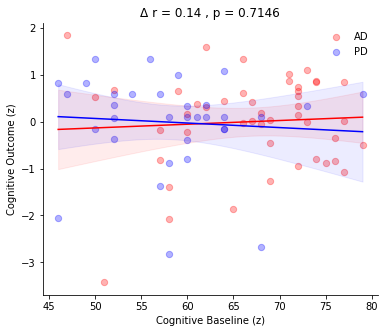

In [70]:
delta_sctr = ScatterWithConfidence(data_df)
delta_sctr_plot = delta_sctr.plot_with_analytic_ci_manual_pvalue(
                                            x_one=independent_variable, x_two=dependent_variable,
                                            split_by=split_by_var, split_value=split_value_var,
                                            x_label=x_label, y_label=y_label,
                                            upper_split_legend=legend_string_for_upper_split, lower_split_legend=legend_string_for_lower_split,
                                            alpha=0.3, manual_p_value=None, permute_column=None,
                                            save=True, out_dir=out_dir,
                                            colour1='#FF0000', colour2='#0000FF')

Saved to /Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/cognition_2023/revisions/baselien_cognition/hist_kde.svg


<Figure size 432x360 with 0 Axes>

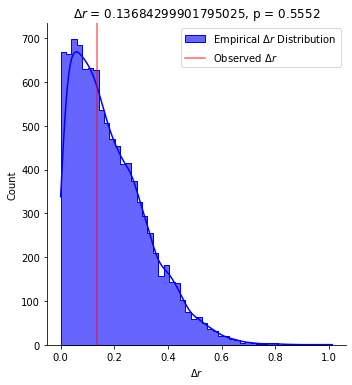

In [71]:
# Create an object from the new Seaborn-based class
histogram_plotter_seaborn = DeltaCorrelation(data_df)

# Generate the histogram using Seaborn
fig = histogram_plotter_seaborn.plot_histogram_of_delta_r(x_one=independent_variable, x_two=dependent_variable, 
                                                    split_by=split_by_var, split_value=split_value_var, 
                                                    n_permutations=10000, 
                                                    permute_columns=[independent_variable, dependent_variable, split_by_var], 
                                                    bins=50,
                                                    one_tail=True, 
                                                    color_palette='coolwarm')

# Overlay Multiple Correlations

In [ ]:
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_lines_of_best_fit_by_combinations(data_df, categorical_columns, x_var, y_var):
    # Find unique values in each column
    unique_values_per_column = [data_df[col].unique() for col in categorical_columns]

    # Generate all possible combinations of these unique values across the columns
    all_combinations = list(itertools.product(*unique_values_per_column))

    plt.figure(figsize=(12, 8))
    sns.set_palette('tab10')
    # For each combination, create a mask and apply it to the DataFrame
    for combination in all_combinations:
        mask = pd.Series(True, index=data_df.index)
        for col, val in zip(categorical_columns, combination):
            mask &= (data_df[col] == val)

        # Apply the mask to the DataFrame to get the subset
        masked_df = data_df[mask]
        
        # Skip if the masked_df is empty
        if masked_df.empty:
            continue

        # Calculate the line of best fit
        slope, intercept = np.polyfit(masked_df[x_var], masked_df[y_var], 1)
        x_vals = np.linspace(masked_df[x_var].min(), masked_df[x_var].max(), 100)
        y_vals = slope * x_vals + intercept

        # Plot the line of best fit
        plt.plot(x_vals, y_vals, label=f'{combination}', linestyle='-')

    plt.xlabel(x_var)
    plt.ylabel(y_var)
    plt.title(f'Lines of Best Fit for {x_var} vs {y_var} by Category Combinations')
    plt.legend(title='Category Combination', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
data_df.columns

In [ ]:
plot_lines_of_best_fit_by_combinations(data_df,
                                       categorical_columns=['Cognitive_Test'], 
                                       x_var='Standardized_Cognitive_Baseline', 
                                       y_var='Z_Scored_Percent_Cognitive_Improvement')

# Correlation Matrix and Heatmap

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_heatmap(dataframe):
    # Calculate the correlation matrix
    corr_matrix = dataframe.corr()

    # Create a heatmap
    plt.figure(figsize=(20, 16))
    sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={'shrink': .5})

    # Adjust the layout
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.title('Correlation Heatmap')

    # Show the plot
    plt.show()


In [ ]:
# Example usage
sorted_columns = sorted(data_df.columns)
data_df_sorted = data_df[sorted_columns]
plot_correlation_heatmap(data_df)

# Canonical Correlation

In [ ]:
from sklearn.cross_decomposition import CCA

def perform_cca(data_df, set1_columns, set2_columns):
    """
    Perform Canonical Correlation Analysis (CCA) between two sets of columns in a DataFrame.

    Parameters:
        data_df (pd.DataFrame): The DataFrame containing the data.
        set1_columns (list): List of column names for the first set of variables.
        set2_columns (list): List of column names for the second set of variables.

    Returns:
        cca (CCA): The CCA model object.
        cca_results (dict): A dictionary containing the CCA results.
    """
    # Extract the specified sets of columns from the DataFrame
    set1_data = data_df[set1_columns]
    set2_data = data_df[set2_columns]

    # Initialize the CCA model
    cca = CCA(n_components=min(len(set1_columns), len(set2_columns)))

    # Fit the CCA model to the data
    cca.fit(set1_data, set2_data)

    # Transform the data using CCA
    set1_transformed, set2_transformed = cca.transform(set1_data, set2_data)

    # Calculate canonical correlations from singular values
    canonical_correlations = cca.singular_values_

    # Store the CCA results in a dictionary
    cca_results = {
        'Canonical Correlations': canonical_correlations,
        'Set 1 Transformed': set1_transformed,
        'Set 2 Transformed': set2_transformed
    }

    return cca, cca_results

define 2 lists
- 1 is the first set to CCA
- 2 is the second set to CCA

In [ ]:
data_df.columns

In [ ]:
templist = []
for val in data_df.columns:
    if 'CSF' in val:
        templist.insert(-1, val)
print(templist)

In [ ]:
list1 = ['frontal', 'temporal', 'parietal', 'occipital',
       'cerebellum', 'Mesial_Temporal', 'ventricle']
list2 = ['frontal_eh', 'temporal_eh', 'parietal_eh',
       'occipital_eh', 'cerebellum_eh']

In [ ]:
from sklearn.cross_decomposition import CCA

def perform_cca(data_df, set1_columns, set2_columns):
    """
    Perform Canonical Correlation Analysis (CCA) between two sets of columns in a DataFrame.

    Parameters:
        data_df (pd.DataFrame): The DataFrame containing the data.
        set1_columns (list): List of column names for the first set of variables.
        set2_columns (list): List of column names for the second set of variables.

    Returns:
        cca (CCA): The CCA model object.
        cca_results (dict): A dictionary containing the CCA results.
    """
    # Extract the specified sets of columns from the DataFrame
    set1_data = data_df[set1_columns]
    set2_data = data_df[set2_columns]

    # Initialize the CCA model
    cca = CCA(n_components=min(len(set1_columns), len(set2_columns)))

    # Fit the CCA model to the data
    cca.fit(set1_data, set2_data)

    # Calculate canonical correlations using the score method
    canonical_correlations = cca.score(set1_data, set2_data)

    # Store the CCA results in a dictionary
    cca_results = {
        'Canonical Correlations': canonical_correlations
    }

    return cca, cca_results


In [ ]:
cca, cca_results = perform_cca(data_df, set1_columns=list1, set2_columns=list2)
cca_results

# Intraclass Correlation

In [ ]:
import matplotlib.patches as mpatches
from pingouin import intraclass_corr
from calvin_utils.statistical_utils.distribution_statistics import BootstrappedDistributionStatistics
from calvin_utils.statistical_utils.resampling_functions import Bootstrap

def calculate_icc(df, col1, col2):
    # Select only the specified columns and rename them for compatibility with pingouin
    data = df[[col1, col2]].rename(columns={col1: 'rating1', col2: 'rating2'})

    # Reshape data for pingouin's intraclass_corr function
    df_melted = data.melt(value_vars=['rating1', 'rating2'], var_name='rater', value_name='rating')
    df_melted['subject'] = df_melted.groupby('rater').cumcount()

    # Calculate ICC
    icc_result = intraclass_corr(data=df_melted, targets='subject', raters='rater', ratings='rating')
    
    # Return ICC(3,1)
    return icc_result.set_index('Type').loc['ICC3', 'ICC']

def bootstrap_icc(data, col1, col2, bootstrap_samples=2500):
    # Perform the bootstrap resampling using the Bootstrap class
    bootstrap = Bootstrap(data=data, func=calculate_icc, func_args={'col1': col1, 'col2': col2}, bootstrap_samples=bootstrap_samples)
    bootstrap_results = bootstrap.bootstrap_function()

    # Calculate the confidence intervals using the BootstrappedDistributionStatistics class
    distribution_statistics = BootstrappedDistributionStatistics(bootstrap_results)
    lower_bound, upper_bound = distribution_statistics.percentile_ci(alpha=0.05)

    return lower_bound, upper_bound

def plot_icc_forest(comparisons_dict, dataframe, bootstrap_samples=2500, full_legend_patches=False):
    # figure = plt.figure(figsize=(4, len(comparisons_dict)*1.2))
    figure = plt.figure(figsize=(4, 5))
    
    # Create a color palette with enough unique colors
    colors = sns.color_palette("tab10", len(comparisons_dict))
    
    # Create legend patches
    legend_patches = []
    
    # Iterate through the dictionary and plot ICC for each comparison
    for idx, (col1_name, col2_name) in enumerate(comparisons_dict.items()):
        # Calculate ICC
        icc_value = calculate_icc(dataframe, col1_name, col2_name)

        # Bootstrap 95% confidence interval
        ci_lower, ci_upper = bootstrap_icc(dataframe, col1_name, col2_name, bootstrap_samples=bootstrap_samples)

        # Plot ICC with confidence interval
        plt.errorbar(x=icc_value, y=idx, xerr=[[icc_value - ci_lower], [ci_upper - icc_value]], fmt='o', color=colors[idx], capsize=5)
        
        # Add legend patch
        if full_legend_patches:
            legend_patches.append(mpatches.Patch(color=colors[idx], label=f'{col1_name} vs {col2_name}'))
        else:
            legend_patches.append(mpatches.Patch(color=colors[idx], label=f'{col1_name}'))

    plt.xlim(0, 1)
    plt.ylim(-1, len(comparisons_dict))
    plt.yticks([])
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.xlabel('ICC')
    plt.title('Intraclass Correlation Coefficients (ICC) with 95% Confidence Intervals')
    plt.grid(axis='x', linestyle='--')
    
    # Add legend
    plt.legend(handles=legend_patches, frameon=False, loc=(0.05, 0.1))
    return figure

Exptl

In [ ]:
data_df['City'].unique()

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# Variables
y_variable = 'Z_Scored_Percent_Cognitive_Improvement'
x_variable = 'Subiculum_Connectivity_T_Redone'

# Filter data for 'young' age group
young_data = data_df[data_df['Age_Group'] == 'old']

# Function to perform bootstrap and calculate correlation differences and individual correlations
def bootstrap_corr_diff(data, y_var, x_var, group_col, n_bootstraps=1000):
    corr_diffs = []
    all_correlations = {group: [] for group in data[group_col].unique()}
    unique_groups = data[group_col].unique()
    
    for _ in range(n_bootstraps):
        sample_diffs = []
        
        for group in unique_groups:
            group_data = data[data[group_col] == group].sample(frac=1, replace=True)
            corr, _ = pearsonr(group_data[x_var], group_data[y_var])
            all_correlations[group].append(corr)
            sample_diffs.append(corr)
        
        if len(sample_diffs) == 2:
            corr_diffs.append(sample_diffs[0] - sample_diffs[1])
    
    return corr_diffs, all_correlations

# Perform bootstrapping
bootstrap_diffs, bootstrap_correlations = bootstrap_corr_diff(young_data, y_variable, x_variable, group_col='City')

# Save the bootstrap differences to a .txt file
np.savetxt('/Users/cu135/Library/CloudStorage/OneDrive-Personal/OneDrive_Documents/Research/2023/subiculum_cognition_and_age/figures/Figures/3_cohort_delta_r/andy_similarity_test/bayes_old/bootstrap_diffs.txt', bootstrap_diffs)

# Save the bootstrap correlations for each city to separate .txt files
for city, correlations in bootstrap_correlations.items():
    np.savetxt(f'/Users/cu135/Library/CloudStorage/OneDrive-Personal/OneDrive_Documents/Research/2023/subiculum_cognition_and_age/figures/Figures/3_cohort_delta_r/andy_similarity_test/bayes_old/bootstrap_correlations_{city}.txt', correlations)



# Generate Correlation Matrix

In [ ]:
data_df.columns

In [ ]:
columns_list = ['Total', 'Attention', 'Memory', 'Fluency', 'Language', 'Visuospatial']

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_heatmap(df, columns, method='pearson'):
    # Calculate the correlation matrix
    corr_matrix = df[columns].corr(method=method)
    
    # Generate a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(f'{method.capitalize()} Correlation Matrix')
    plt.show()


In [ ]:

plot_correlation_heatmap(data_df, columns_list, method='spearman')